Feature selection is an essential task in machine learning. Usually al

* [1] (LassoNet: A Neural Network with Feature Sparsity. Ismael Lemhadri, Feng Ruan, Louis Abraham, Robert Tibshirani)[https://arxiv.org/abs/1907.12207]

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer
from tf_lassonet.model import LassoNet
from tf_lassonet.path import LassoPath
from tensorflow.keras.layers import Flatten, Dense, Reshape, Add
from tensorflow.keras import Input, Model
import tensorflow as tf
import numpy as np

# Initial dataset

Let's createaan MNIST version with only two digits

In [2]:

(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def keep_5_and_6(x, y):
    if y == 5 or y == 6:
        return True
    else:
        return False


def to_binary(x, y):
    if y== 5:
        return x, 0
    else:
        return x, 1


2022-05-02 14:12:30.920523: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-02 14:12:30.920554: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lolemi): /proc/driver/nvidia/version does not exist
2022-05-02 14:12:30.921714: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label
BATCH_SIZE = 2048

ds_train = (
    ds_train.filter(keep_5_and_6)
    .map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(to_binary)
    .cache()
    .shuffle(ds_info.splits["train"].num_examples)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

ds_test = (
    ds_test.filter(keep_5_and_6)
    .map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(to_binary)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Model
We create ur model as a simple convolutional layer 

In [4]:

model = Sequential(
    [
        InputLayer((28, 28, 1)),        
        Conv2D(5, (3,3), activation="relu", name="conv"),
        Flatten(),        
        Dense(1, name="classes"),
    ]
)

# LASSO NET

Given a defined model it is possible to attach the lasso-net model to our model by just placing our model inside the framework


In [24]:
model_input_shape = model.input.shape[1:]
input_n_dim = np.prod(model_input_shape)
output_dim = np.prod(model.layers[-1].output_shape[1:])

input = Input((28, 28, 1))
x = Flatten()(input)
x = Dense(input_n_dim)(x)
x = Reshape(model_input_shape)(x)
x = model(x)

skip = Flatten()(input)
skip = Dense(output_dim)(skip)
x = Add()([x, skip])
lasso_net_model = Model(input, x)
lasso_net_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam')

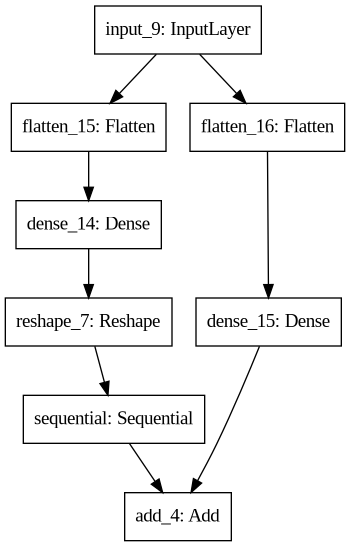

In [25]:

tf.keras.utils.plot_model(lasso_net_model)

In [29]:
epochs = 10
for epoch in range(epochs):
    for step, (x_batch_train, y_batch_train) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            logits = lasso_net_model(x_batch_train, training=True) 
            loss_value = lasso_net_model.compiled_loss(y_batch_train, logits)

        grads = tape.gradient(loss_value, model.trainable_weights)
        lasso_net_model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # MISSING -> proximal_update()

## Proximal update

The proximal update is the only modification we need to perform in our training step. After we back-propagate the gradients

Let's follow the Algorithm 4 Group Hierarchical Proximal Operator
Sort the coordinates of 

$W_j^{(1)}$ into $|W_{(j,1)}^{(1)}| \geq ... \geq |W_{(j,K)}^{(1)}|$

```python
W_abs_sorted = tf.sort(tf.abs(W), axis=1)[:, ::-1]
```

for $m \in \{0, ..., K \}$

   $w_{j,m} \leftarrow \dfrac{M}{1+mM^2} * S_{\lambda}\left( \left|\left|\theta_j \right|\right|_2 + M \sum\limits_{j=1}^m \left| W_{j}^{(1)}\right| \right)$

In [ ]:
def hier_prox_group(skip, W, *, lambda_, M, lambda_bar=0):
    n_features, output_size = W.shape
    zeros = tf.zeros((n_features, 1))
    W_abs_sorted = tf.sort(tf.abs(W), axis=1)[:, ::-1]
    cumulative_sum = tf.concat(
        [zeros, tf.cumsum(W_abs_sorted - lambda_bar, axis=1)], axis=1
    )

    m = tf.range(0.0, output_size + 1.0, dtype=tf.float32)
    q = 1 / (1 + m * M ** 2)

    norm_skip = tf.expand_dims(tf.norm(skip, axis=1, ord=2), axis=1)

    # w = q*tf_soft_threshold(lambda_, norm_skip + M*cumulative_sum)

    t = q * tf.nn.relu(1 - (lambda_ - M * cumulative_sum) / norm_skip)
    w = M * t * norm_skip
    x = t

    lower = tf.concat([tf_soft_threshold(lambda_bar, W_abs_sorted), zeros], axis=1)
    idx = tf.reduce_sum(tf.cast(lower > w, dtype=tf.int32), axis=1)

    idx = tf.stack(
        [
            tf.range(0, w.shape[0]),
            idx,
        ],
        axis=1,
    )

    w = tf.expand_dims(tf.gather_nd(w, idx), axis=1)
    x = tf.expand_dims(tf.gather_nd(x, idx), axis=1)

    # skip_star = (1/M)*(tf.sign(skip)*tf.broadcast_to(tf.expand_dims(w,axis=1), skip.shape))

    skip_star = skip * x
    W_star = tf.sign(W) * tf.math.minimum(w, tf.abs(W))

    return skip_star, W_star

In [ ]:
Lets analyze the function a little bit

# Examples